# Simple Stock Price Prediction Model

Created by Marc Zeugin

### Import modules

In [1]:
from numpy.random import seed
seed(1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from nn_models import lstm_prediction, dnn_prediction
from sklearn.model_selection import train_test_split
from plot_graph import plot_v_models, plot_v_stocks
from sklearn.preprocessing import MinMaxScaler
from get_stock_data import get_stock_data
from get_macro_data import get_macro_data
from models import predict_regression
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from forecast import user_input
plt.style.use('seaborn-whitegrid')
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")
import math

### Set options

In [2]:
models = ['L', 'R', 'LR', 'ET', 'RF', 'GBR'] # available options are CBR (CatBoostRegressor), RF (RandomForestRegressor), SVM (SupportVectorRegressor), HGBR (HistGradientBoostingRegressor)
# GBR (GradientBoostingRegressor), ABR (AdaBoostRegressor), GPR (GaussianProcessRegressor), R (Ridge), LL (LassoLars), BR (BayesianRidge), XGB (XGBRegressor),
# KNN (KNeighborsRegressor), L (Lasso), MLP (MLPRegressor), LGBM (LGBMRegressor), ET (ExtraTreeRegressor) LR (LinearRegression), XGBRF (XGBRFRegressor),
# PR (PoissonRegressor), PAR (PassiveAggressiveRegressor), BaR (BaggingRegressor)
training_data_split = 0.8 # as a decimal
shift = 3 # in days
new_stocks = [] # add strings of symbols of new stocks to include
start_date = "2016-01-01" # start date of stock data
end_date = "2021-12-29" # end date of stock data
cv_num = 3 # number of crossvalidations to do for hyperparameter tuning
trial_num = 100 # number of trials to find optimal hyperparameters

### Load financial data from yahoo finance API or local folder if available

In [3]:
ticker_hist_list, tickers = get_stock_data(new_stocks, start_date, end_date)

### Display all stock closing price plots

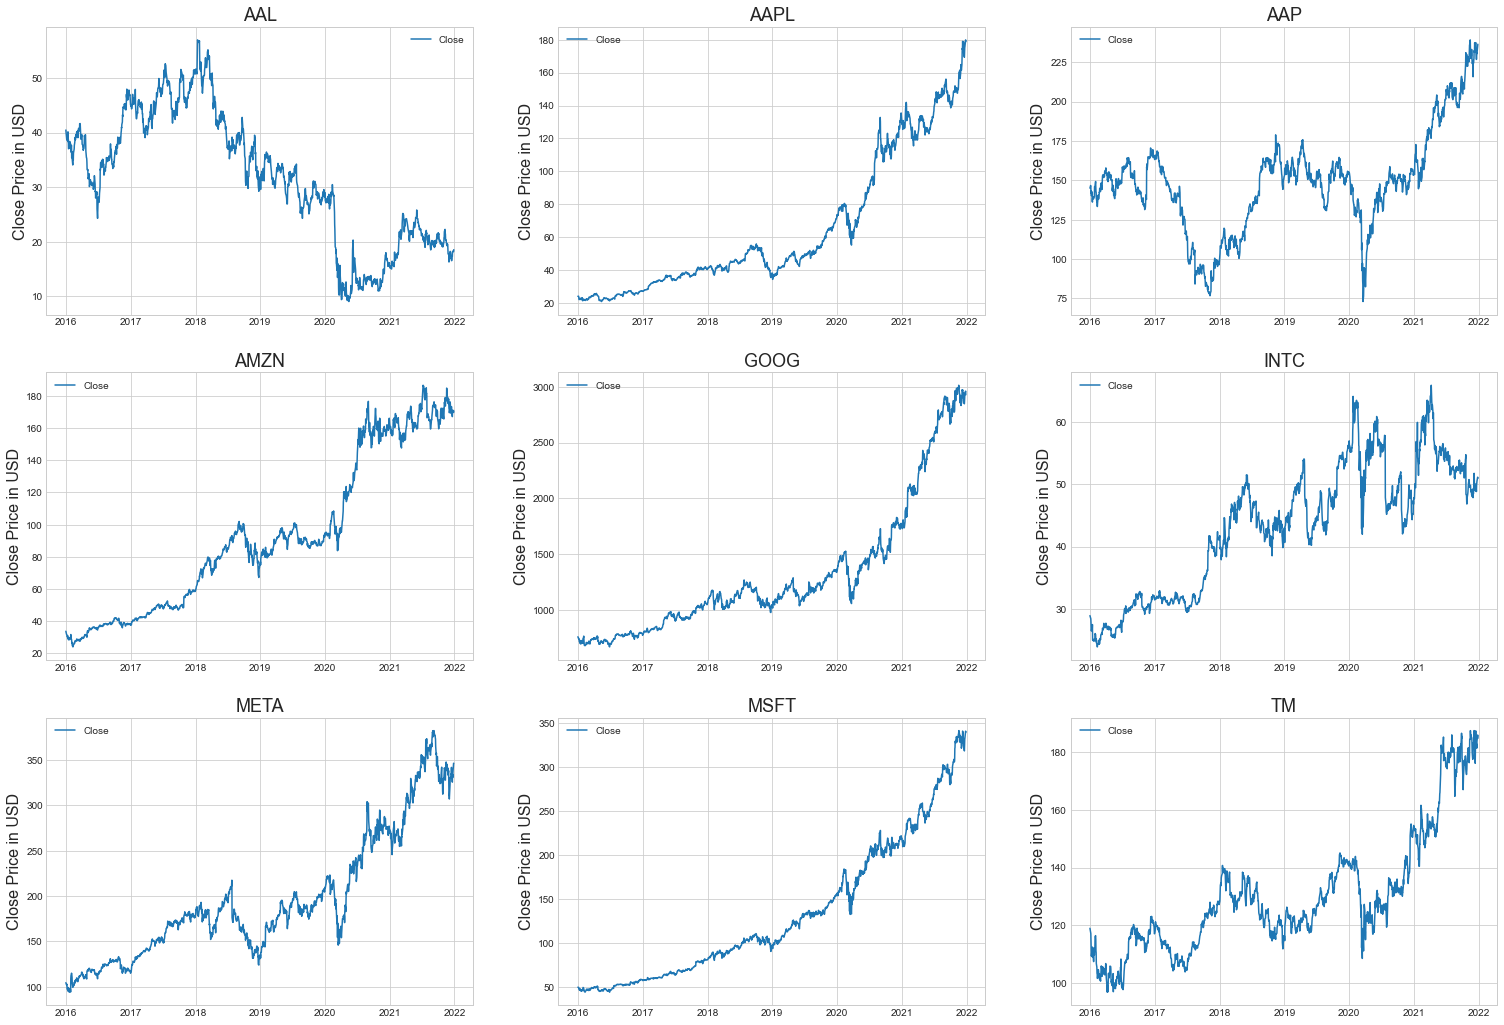

In [4]:
plot_v_stocks(tickers, ticker_hist_list)

### Create one dataset with all stock data

In [5]:
stock_data = pd.concat(ticker_hist_list, axis=1)
col_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
stock_data.columns = [col_name + '.' + ticker for ticker in tickers for col_name in col_names]
stock_data.index.name = 'Date'
print(stock_data.shape)

(1509, 63)


In [6]:
stock_data.describe()

,Open.AAL,High.AAL,Low.AAL,Close.AAL,Volume.AAL,Dividends.AAL,Stock Splits.AAL,Open.AAPL,High.AAPL,Low.AAPL,...,Volume.MSFT,Dividends.MSFT,Stock Splits.MSFT,Open.TM,High.TM,Low.TM,Close.TM,Volume.TM,Dividends.TM,Stock Splits.TM
count,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03,1509.000000,1509.0,1509.000000,1509.000000,1509.000000,...,1.509000e+03,1509.000000,1509.0,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03,1509.000000,1509.0
mean,31.861866,32.366335,31.326608,31.823106,2.260404e+07,0.001127,0.0,64.860656,65.564819,64.195962,...,2.891730e+07,0.007329,0.0,130.089710,130.671150,129.407525,130.057355,2.392541e+05,0.002510,0.0
std,12.000448,12.067093,11.953753,12.018732,3.264196e+07,0.010558,0.0,41.397700,41.904273,40.900228,...,1.330391e+07,0.058424,0.0,20.858355,20.973081,20.743255,20.879439,1.508416e+05,0.069053,0.0
min,8.770000,9.190000,8.250000,9.040000,1.352400e+06,0.000000,0.0,20.899751,21.287557,20.776678,...,7.425600e+06,0.000000,0.0,96.758881,97.605991,96.335316,96.798271,4.840000e+04,0.000000,0.0
25%,21.430000,21.809999,21.020000,21.420000,5.685200e+06,0.000000,0.0,35.856740,36.226113,35.476306,...,2.062880e+07,0.000000,0.0,116.209999,117.089996,115.710733,116.398193,1.405000e+05,0.000000,0.0
50%,32.709352,33.131338,31.953317,32.538643,8.418300e+06,0.000000,0.0,46.447855,46.882947,46.127097,...,2.539070e+07,0.000000,0.0,125.320000,125.790001,124.720001,125.260002,1.947000e+05,0.000000,0.0
75%,41.272089,41.952318,40.730945,41.276730,2.898830e+07,0.000000,0.0,89.978680,91.060174,88.889780,...,3.312170e+07,0.000000,0.0,137.949997,138.679993,137.520004,138.149994,2.926000e+05,0.000000,0.0
max,57.300624,57.583278,56.335700,56.988731,4.286171e+08,0.100000,0.0,180.624141,181.631386,178.041235,...,1.335030e+08,0.620000,0.0,187.869995,188.949997,187.139999,187.440002,1.415500e+06,2.015000,0.0


### Pull macroeconomic data from API

In [7]:
macro_data = get_macro_data('FRED', True) # Specify the API to use (FRED, IMF or WB) and whether to load from macrodata.csv or download data

### Adjust datastructure to match stock data

In [8]:
for index in macro_data.index:
    if index not in stock_data.index:
        macro_data.drop(index, axis=0, inplace=True)
print(macro_data.shape)

(1509, 41)


In [9]:
macro_data.describe()

,10-Year Breakeven Inflation Rate,5-Year Breakeven Inflation Rate,Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity,Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity,Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity,Moodys Seasoned Aaa Corporate Bond Yield,Moodys Seasoned Baa Corporate Bond Yield,Unemployment Rate,S&P/Case-Shiller U.S. National Home Price Index,Export Price Index (End Use),...,U.S. Dollars to Euro Spot Exchange Rate,U.S. Dollars to U.K. Pound Sterling Spot Exchange Rate,"Securities in Bank Credit, All Commercial Banks","Consumer Loans, All Commercial Banks","Total Assets, All Commercial Banks","Bank Credit, All Commercial Banks","Trade Balance: Goods and Services, Balance of Payments Basis",Brave-Butters-Kelley Real Gross Domestic Product,Index of Global Real Economic Activity,Passenger Car Registrations in United States
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,...,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000
mean,1.850570,1.766428,1.925149,1.556170,1.230272,3.316872,4.220384,5.046786,211.069569,126.208416,...,1.143733,1.319312,3863.248611,3.881378,6.090325,5.804374,-50344.454606,2.138624,-26.227912,65.852993
std,0.339834,0.459228,0.695250,0.790924,0.871619,0.593580,0.620516,2.073704,26.389502,6.837983,...,0.044772,0.059979,720.382617,6.880820,12.281194,6.030950,11000.554834,13.597066,55.269668,18.027679
min,0.990000,0.670000,0.620000,0.270000,0.120000,2.140000,3.160000,3.500000,175.054000,118.100000,...,1.054500,1.216000,3110.555500,-37.500000,-9.700000,-1.100000,-78867.000000,-71.085194,-162.723760,25.668936
25%,1.620000,1.530000,1.520000,0.860000,0.240000,2.790000,3.640000,3.800000,192.287000,121.600000,...,1.109800,1.281000,3367.000000,2.700000,1.400000,2.900000,-55070.000000,1.591511,-59.885494,50.552285
50%,1.830000,1.710000,1.810000,1.560000,1.240000,3.510000,4.300000,4.400000,205.396000,125.100000,...,1.136400,1.310100,3493.829500,4.500000,4.000000,4.700000,-46809.000000,2.539580,-25.132702,67.687934
75%,2.100000,1.990000,2.430000,2.050000,1.840000,3.850000,4.680000,5.100000,219.846000,127.300000,...,1.178500,1.370100,4170.894800,6.900000,7.900000,7.300000,-41719.000000,3.736078,4.476830,80.268773
max,2.620000,2.980000,3.150000,3.000000,2.860000,4.220000,5.460000,14.700000,278.474000,146.500000,...,1.234000,1.498100,5678.964000,12.000000,76.900000,40.500000,-36801.000000,48.540313,108.454630,95.480861


### Add macroeconomic data to dataset

In [10]:
all_data = pd.concat([stock_data, macro_data], axis=1)
print(all_data.shape)

(1509, 104)


### Add lagged features to the dataset

In [12]:
for col in all_data:
    for i in range(1, shift):
        all_data[col + str(-i)] = all_data[col].shift(i)

In [13]:
# remove first i instances because of NaN from backward shifting
for i in range(1, shift):
    all_data.drop(index=all_data.index[0], axis=0, inplace=True)

### Split into train and test

In [14]:
colum_name = f'Close.{"AAP"}'

X = all_data.copy()
X = X.drop(columns=[colum_name])
y = all_data[colum_name].copy()

print(f'X shape: {X.shape} & y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=False)

print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} & y_test shape: {y_test.shape}')

X shape: (1507, 311) & y shape: (1507,)
X_train shape: (1205, 311) & X_test shape: (302, 311)
y_train shape: (1205,) & y_test shape: (302,)


### Apply MinMaxScaler to dataset

In [15]:
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.fit_transform(y_test.values.reshape(-1, 1))
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')

X_train shape: (1205, 311) & X_test shape: (302, 311)
X_train shape: (1205, 311) & X_test shape: (302, 311)


### Reshape input for LSTM model to match requirements

In [16]:
X_train_nn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_nn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f'X_train_nn shape: {X_train_nn.shape} & X_test_nn shape: {X_test_nn.shape}')
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
print(f'y_train_nn shape: {y_train.shape} & y_test_nn shape: {y_test.shape}')

X_train_nn shape: (1205, 311, 1) & X_test_nn shape: (302, 311, 1)
y_train_nn shape: (1205, 1) & y_test_nn shape: (302, 1)


### Fit LSTM model

In [17]:
history_lstm, test_predict_lstm = lstm_prediction(X_train_nn, y_train_nn, X_test_nn, y_test_nn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 311, 100)         20800     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 311, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 311, 50)           30200     
                                                                 
 dropout_1 (Dropout)         (None, 311, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                        

dict_keys(['loss', 'val_loss'])


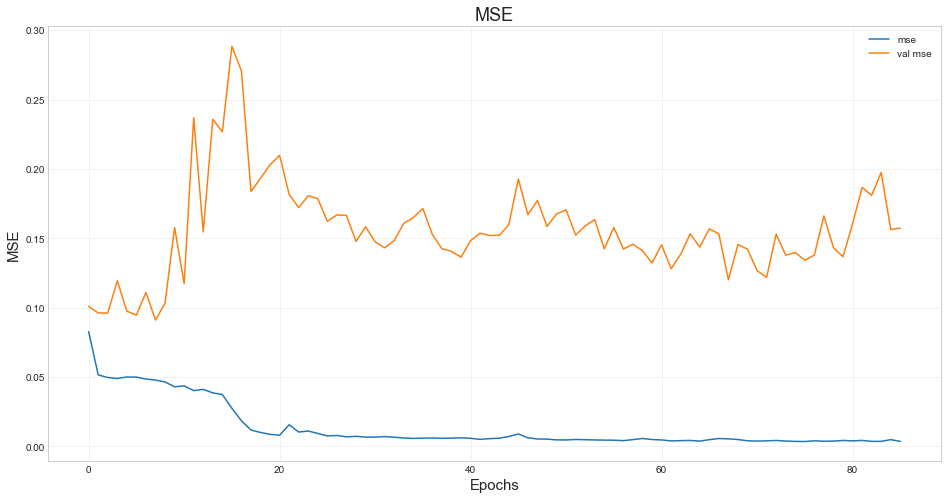

In [18]:
print(history_lstm.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history_lstm.epoch, history_lstm.history['loss'], label = "mse")
plt.plot(history_lstm.epoch, history_lstm.history['val_loss'], label = "val mse")
plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Calculate RMSE and MAE

In [19]:
print(f'RMSE: {math.sqrt(mean_squared_error(y_test, test_predict_lstm))}')
print(f'MSE: {mean_squared_error(y_test, test_predict_lstm)}')
print(f'MAE: {mean_absolute_error(y_test, test_predict_lstm)}')

RMSE: 0.3965679511113767
MSE: 0.15726613984867527
MAE: 0.3467890815487969


### Plot prediction vs actual close price

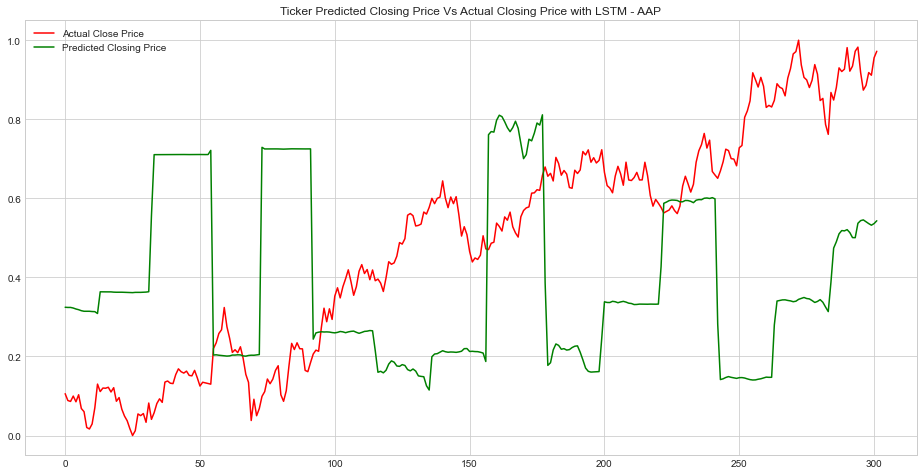

In [20]:
plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price with LSTM - {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict_lstm, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Inverse predictions (if needed)

In [21]:
# y_test = scaler_y.inverse_transform(y_test)
# test_predict_lstm = scaler_y.inverse_transform(test_predict_lstm)

### Fit LSTM model

In [22]:
history_dnn, test_predict_dnn = dnn_prediction(X_train_nn, y_train_nn, X_test_nn, y_test_nn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 311, 100)          200       
                                                                 
 dense_3 (Dense)             (None, 311, 75)           7575      
                                                                 
 dense_4 (Dense)             (None, 311, 50)           3800      
                                                                 
 dense_5 (Dense)             (None, 311, 25)           1275      
                                                                 
 flatten (Flatten)           (None, 7775)              0         
                                                                 
 dense_6 (Dense)             (None, 12)                93312     
                                                                 
 dense_7 (Dense)             (None, 6)                

dict_keys(['loss', 'val_loss'])


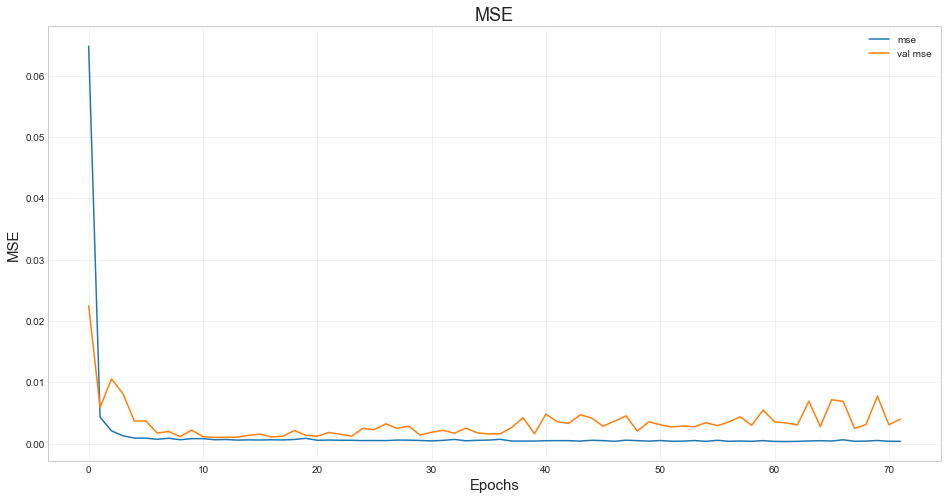

In [23]:
print(history_dnn.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history_dnn.epoch, history_dnn.history['loss'], label = "mse")
plt.plot(history_dnn.epoch, history_dnn.history['val_loss'], label = "val mse")
plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Calculate RMSE and MAE

In [24]:
print(f'RMSE: {math.sqrt(mean_squared_error(y_test, test_predict_dnn))}')
print(f'MSE: {mean_squared_error(y_test, test_predict_dnn)}')
print(f'MAE: {mean_absolute_error(y_test, test_predict_dnn)}')

RMSE: 0.06301093217851501
MSE: 0.003970377574005419
MAE: 0.051703450386961884


### Plot prediction vs actual close price

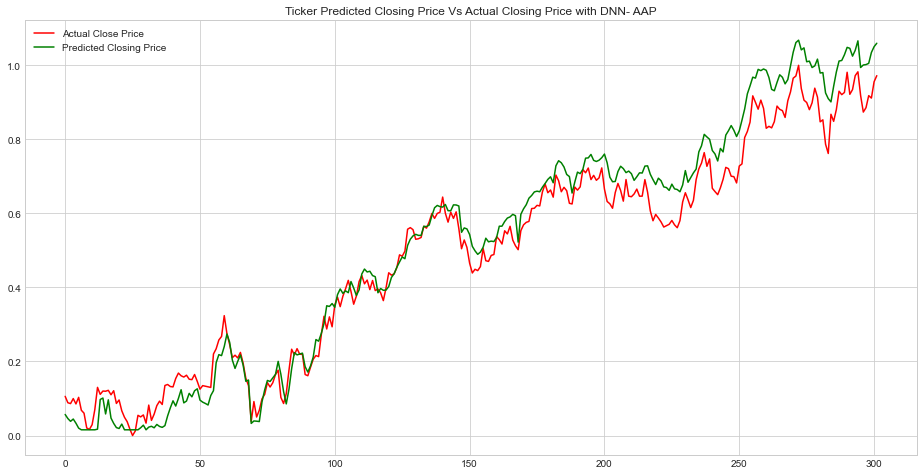

In [25]:
plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price with DNN- {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict_dnn, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Preparation for non-NN Models

In [26]:
X = stock_data.drop([f'Close.{"AAP"}'], axis=1)
y = stock_data[f'Close.{"AAP"}']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=False)
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
print(f'Training sample size: {X_train.shape[0]} and testing sample size: {X_test.shape[0]}.')

Training sample size: 1207 and testing sample size: 302.


### Apply MinMaxScaler to dataset

In [27]:
scaler_x2 = MinMaxScaler()
scaler_y2 = MinMaxScaler()
X_train = scaler_x2.fit_transform(X_train)
X_test = scaler_x2.fit_transform(X_test)
y_train = scaler_y2.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y2.fit_transform(y_test.values.reshape(-1, 1))

### Prediction with selected models

In [33]:
y_pred, studies = predict_regression(models, X_train, y_train, X_test, cv_num, trial_num)

{'alpha': 6.693880432444763e-06, 'fit_intercept': True}
done with L
{'alpha': 0.02189476275968682, 'fit_intercept': True}
done with R
{'fit_intercept': False}
done with LR
{'max_depth': 80, 'min_samples_leaf': 3, 'min_samples_split': 6, 'max_features': 'auto'}
done with ET
{'n_estimators': 165, 'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'max_features': 'auto'}
done with RF
{'n_estimators': 70, 'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 7}
done with GBR


In [34]:
x = PrettyTable()
x.field_names = ["Model", "R2 Score", 'RMSE', 'MAE', 'Max Error']

for key, value in y_pred.items():
    x.add_row([key, format(r2_score(y_test, value), '.4f'), format(math.sqrt(mean_squared_error(y_test, value)), '.4f'), \
               format(mean_absolute_error(y_test, value), '.4f'), format(max_error(y_test, value), '.4f')])

print(x)

+-------+----------+--------+--------+-----------+
| Model | R2 Score |  RMSE  |  MAE   | Max Error |
+-------+----------+--------+--------+-----------+
|   L   |  0.9970  | 0.0154 | 0.0126 |   0.0418  |
|   R   |  0.9974  | 0.0144 | 0.0116 |   0.0362  |
|   LR  |  0.9975  | 0.0140 | 0.0112 |   0.0384  |
|   ET  |  0.9886  | 0.0302 | 0.0232 |   0.0884  |
|   RF  |  0.9942  | 0.0216 | 0.0167 |   0.0928  |
|  GBR  |  0.9934  | 0.0229 | 0.0177 |   0.0798  |
+-------+----------+--------+--------+-----------+


### Plot prediction vs actual close price

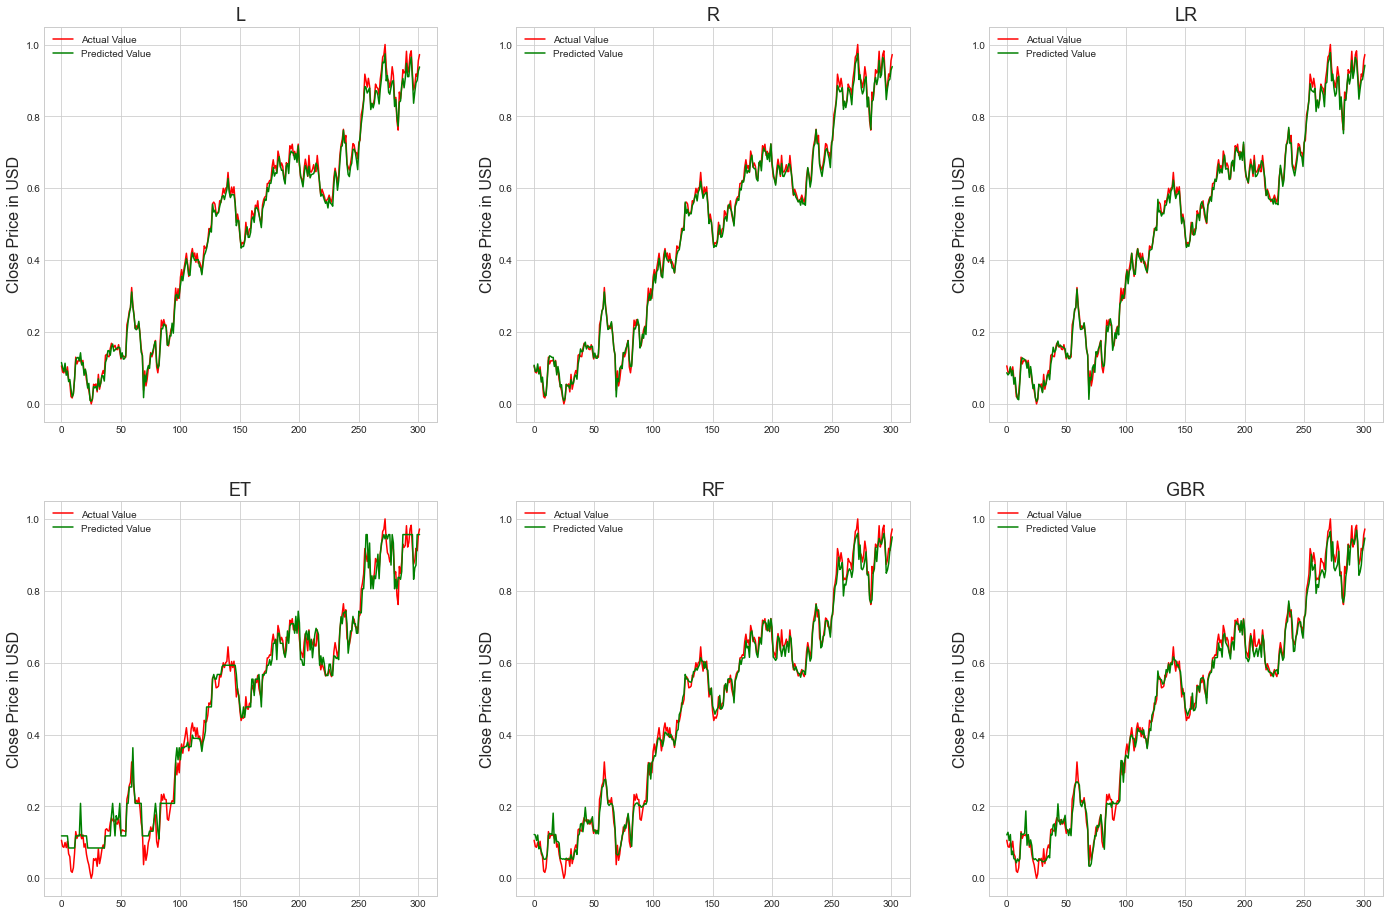

In [35]:
plot_v_models(models, y_test, y_pred)

### Function to predict user selected stock performance

In [36]:
# user_input()